In [1]:
# импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from scipy import stats 
import numpy as np
import shap


import warnings
warnings.filterwarnings("ignore")

# <a class="anchor" id="0"></a><font color='#ad2f2d'>Навигация</font>
**1. [Постановка задачи](#1)** <br>

**2. [Анализ данных и предобработка](#2)** <br>

**3. [Исследование рынка авиабилетов](#3)** <br>

**4. [Кодирование переменных, обработка выбросов](#4)** <br>

**5. [Признак важности по Шепли](#5)** <br>

**6. [Модель прогноза цены авиабилета](#6)** <br>

**7. [Итог: лучшая модель](#7)** <br>

## <a class="anchor" id="1"></a>1. Постановка задачи
[Вернуться к навигации](#0)
<br>

В рамках данной работы предполагается провести анализ данных о продажах билетов индийских авиакомпаний. 
<br>

Основной **целью** является создание модели, способной эффективно прогнозировать цену билета (целевая переменная — price). Для достижения этого необходимо выполнить разведочный анализ данных, выявить ключевые зависимости и особенности данных, а также применить подходящие модели машинного обучения для прогнозирования.


<br>
Для сравнения моделей выбрана метрика скорректированного R-квадрата (Adjusted $R^2$, $R^2_{скорр}$). В отличие от обычного $R^2$, $R^2_{скорр}$ учитывает количество предикторов, обеспечивая более объективную оценку качества модели. Он помогает снизить риск переобучения, что важно для обеспечения хорошей обобщающей способности. Использование $R^2_{скорр}$ позволяет корректно сравнивать модели с разным числом признаков, выбирая оптимальную с наилучшим балансом между точностью и сложностью.

## <a class="anchor" id="2"></a>2.  Анализ данных и предобработка
[Вернуться к навигации](#0)
<br>
Загрузим данные, соединив два датасета по столбцу "filghtId".
<br>

Далее познакомимся с данными: 
* посмотрим на общую информацию датасета
* посмотрим на описательную статистику
* проверим наличие пропусков
* проверим наличие дубликатов 
* посмотрим на выбросы в данных 


In [2]:
data1 = pd.read_csv('flight price predict.csv')
data2 = pd.read_csv('flight price predict_y.csv')
df = pd.merge(data1, data2, on='filghtId', how='inner')  
df.head(1)

,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,price
0,252589,Vistara,UK-808,Bangalore,Early_Morning,one,Night,Mumbai,13.25,46,69244


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 5697
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filghtId          5698 non-null   int64  
 1   airline           5698 non-null   object 
 2   flight            5698 non-null   object 
 3   source_city       5698 non-null   object 
 4   departure_time    5698 non-null   object 
 5   stops             5698 non-null   object 
 6   arrival_time      5698 non-null   object 
 7   destination_city  5698 non-null   object 
 8   duration          5698 non-null   float64
 9   days_left         5698 non-null   int64  
 10  price             5698 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 534.2+ KB


In [4]:
#описательная статистика для всех данных
df.describe(include='all')

,filghtId,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left,price
count,5698.000000,5698,5698,5698,5698,5698,5698,5698,5698.000000,5698.000000,5698.000000
unique,NaN,6,283,6,6,3,6,6,NaN,NaN,NaN
top,NaN,Vistara,UK-836,Mumbai,Morning,one,Night,Mumbai,NaN,NaN,NaN
freq,NaN,3694,84,1215,1412,5149,1763,1127,NaN,NaN,NaN
mean,252173.147771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.643054,25.750439,52037.046508
std,29757.539642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830058,13.519183,13100.508085
min,8339.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.000000,2339.000000
25%,229691.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.750000,14.000000,44583.000000
50%,252872.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,26.000000,53164.000000
75%,276143.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.580000,37.000000,60260.000000


In [5]:
#посмотрим на уникальные значения в некоторых столбцах
for col in ['airline', 'source_city', 'departure_time',
           'stops', 'arrival_time', 'destination_city']:
    print(col, df[col].unique())
    print('---')

airline ['Vistara' 'Air_India' 'SpiceJet' 'GO_FIRST' 'AirAsia' 'Indigo']
---
source_city ['Bangalore' 'Delhi' 'Mumbai' 'Chennai' 'Kolkata' 'Hyderabad']
---
departure_time ['Early_Morning' 'Morning' 'Night' 'Evening' 'Afternoon' 'Late_Night']
---
stops ['one' 'zero' 'two_or_more']
---
arrival_time ['Night' 'Evening' 'Morning' 'Early_Morning' 'Afternoon' 'Late_Night']
---
destination_city ['Mumbai' 'Chennai' 'Delhi' 'Bangalore' 'Kolkata' 'Hyderabad']
---


In [6]:
#проверка на дубликаты
df.duplicated().sum()

0

**Дубликаты отсутствуют**

In [7]:
#проверка пропусков
df.isna().sum()

filghtId            0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
duration            0
days_left           0
price               0
dtype: int64

**Пропуски отсутствуют**

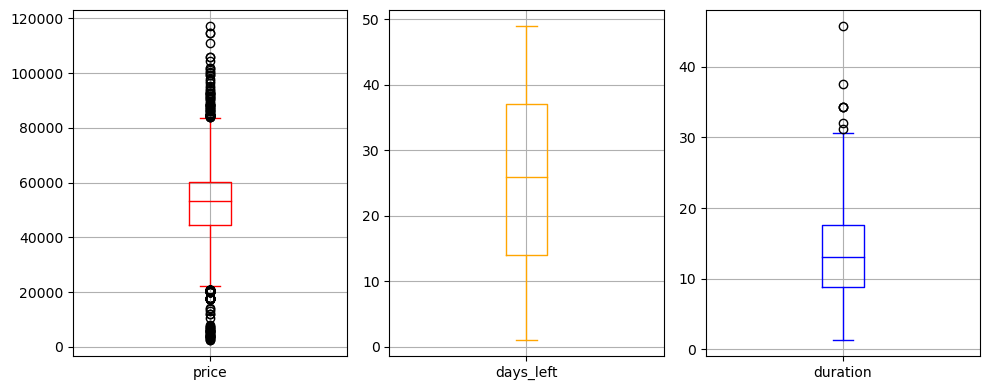

In [8]:
#Проверим наличие выбросов 
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
df.boxplot(column=['price'], color='red')
plt.subplot(1, 3, 2)
df.boxplot(column=['days_left'], color='orange')

plt.subplot(1, 3, 3)
df.boxplot(column=['duration'], color='blue')

plt.tight_layout()
plt.show()

**Структурируем всю полученную ранее информацию**
|Название столбца|Описание||
|-|--------|---|
|filghtId|Уникальный номер билета|int64|
|airline|Название авиакомпании|object: 'Vistara', 'Air_India', 'SpiceJet', 'GO_FIRST', 'AirAsia','Indigo'|
|flight|Номер рейса|object|
|source_city|Город отправления|object: 'Bangalore', 'Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Hyderabad'|
|departure_time|Время суток отправления|object: 'Early_Morning', 'Morning', 'Night', 'Evening', 'Afternoon','Late_Night'|
|stops|Число пересадок|object: 'one', 'zero', 'two_or_more'|
|arrival_time|Время суток прилета|object: 'Early_Morning', 'Morning', 'Night', 'Evening', 'Afternoon','Late_Night'|
|destination_city|Город назначения|object: 'Bangalore', 'Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Hyderabad'|
|duration|Продолжительность поездки|float64|
|days_left| Количество дней до полета|int64|
|price|Цена за билет|int64|

* Столбцы filghtId и flight кажутся неинформативными для нашей задачи, удалим их 
* Пропуски и дубликаты не обнаружены.
* В данных присутствуют выбросы в столбцах price, duration, которые [необходимо обработать.](#4)


[Вернуться в начало раздела](#2)

In [9]:
#удалим столбцы
df = df.drop(columns=['filghtId', 'flight'])
print("после удаления столбцов размерность датасета составляет:",df.shape)

после удаления столбцов размерность датасета составляет: (5698, 9)


## <a class="anchor" id="3"></a>3. Исследование рынка авиабилетов
[Вернуться к навигации](#0)


В данном разделе будут даны ответы на следующие вопросы:
* [Как распределяется цена на билеты](#3.1)
* [Как средняя цена изменяется в зависимости от маршрута (город отлета и прилета)](#3.2)
* [Как средняя цена изменяется в зависимости от времени отлета и прилета](#3.3)
* [Как распределяется цены в зависимости от авиакомпании и количества пересадок](#3.4)
* [Как влияет дата покупки билета на цену](#3.5)
<br>

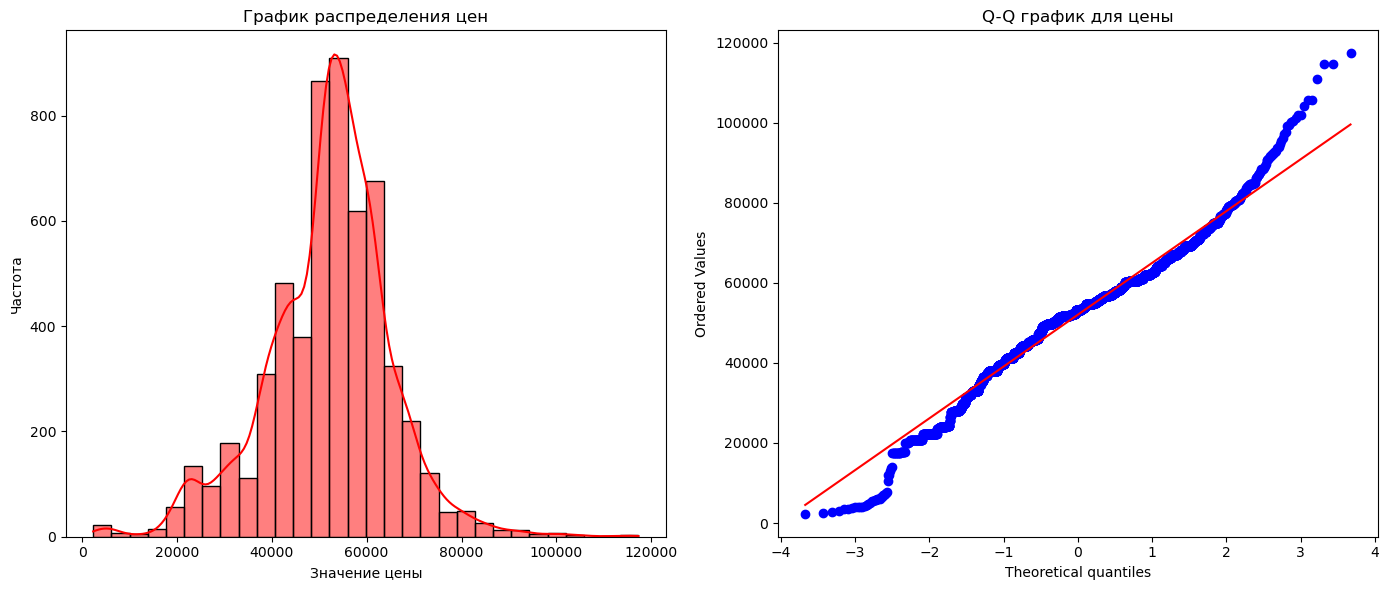

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма с KDE
sns.histplot(df['price'], bins=30, kde=True, color='red', ax=axes[0])
axes[0].set_title('График распределения цен')
axes[0].set_xlabel('Значение цены')
axes[0].set_ylabel('Частота')

# QQ-график
stats.probplot(df['price'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q график для цены')

plt.tight_layout()
plt.show()

In [11]:
# Выполняем тест Дагостино
dagostino_test = stats.normaltest(df['price'])
statistic, p_value = dagostino_test
print(f'Статистика: {statistic}')
print(f'p-значение: {p_value}')

if p_value > 0.05:
    print('Распределение нормально распределено (не отвергаем нулевую гипотезу).')
else:
    print('Распределение не нормально распределено (отвергаем нулевую гипотезу).')

Статистика: 239.24399570566155
p-значение: 1.1189905484397812e-52
Распределение не нормально распределено (отвергаем нулевую гипотезу).


<a class="anchor" id="3.1"></a>**Вывод**

По графикам видно, что распределение цены на билеты близко к нормальному, однако статистический тест (критерий Д’Агостино) этого не подтверждает. Это может быть связано с большой выборкой (более 5000 наблюдений), при которой даже небольшие отклонения становятся статистически значимыми. Поэтому, основываясь на визуальных признаках, можно предположить, что распределение является приближенно нормальным.
<br>

Из этого можно сделать вывод, что особые преобразование не нужны (например, логарифмические или Бокс-Кокс), однако стоит удалить выбросы, это может помочь улучшить значения метрики.

[Вернуться в начало раздела](#3)

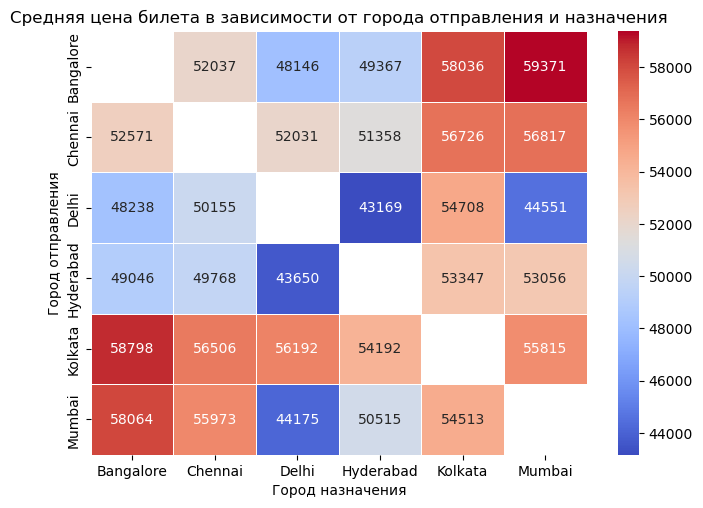

In [12]:
price_pivot_city = df.pivot_table(index='source_city', columns='destination_city', values='price', aggfunc='mean')

plt.figure(figsize=(8, 5.5))
sns.heatmap(price_pivot_city, cmap = 'coolwarm',annot=True, fmt=".0f", linewidths=0.5)
plt.title('Средняя цена билета в зависимости от города отправления и назначения')
plt.xlabel('Город назначения')
plt.ylabel('Город отправления')
plt.show()

<a class="anchor" id="3.2"></a>**Вывод**
    
* Видно, что из Колкаты в любой город назначения, а также из Мумбаи цена выше, чем из других городов.
* Маршрут из Бангалора в Мумбаи самый дорогой (59371), за ним следует маршрут из Бангалора в Колкату (58036), а также вылет из Калькутты в Бангалор (58798).
* Маршрут из Хайдарабада в Дели (43650) и из Мумбаи в Дели (44175) самые дешевые

[Вернуться в начало раздела](#3)

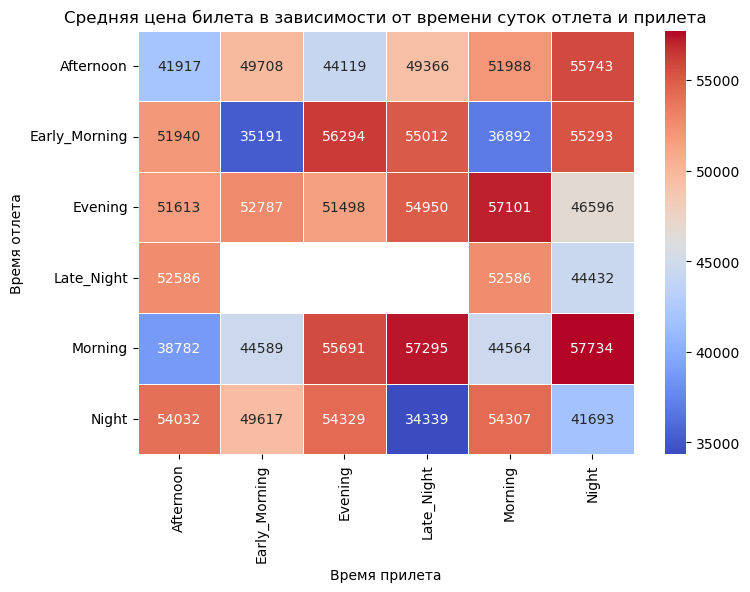

In [13]:
price_pivot_time = df.pivot_table(index='departure_time', columns='arrival_time', values='price', aggfunc='mean')

plt.figure(figsize=(8, 5.5))
sns.heatmap(price_pivot_time, cmap = 'coolwarm',annot=True, fmt=".0f", linewidths=0.5)
plt.title('Средняя цена билета в зависимости от времени суток отлета и прилета')
plt.xlabel('Время прилета')
plt.ylabel('Время отлета')
plt.show()

<a class="anchor" id="3.3"></a>**Вывод**
* Самый дорогой вариант: Morning -> Night является самым дорогим вариантом.
* Самый дешевый вариант: Night -> Late_Night является самым дорогим вариантом.
* Нет комбинаций перелетов: Late_Night -> Early_Morning, Late_Night -> Evening, Late_Night -> Late_Night

[Вернуться в начало раздела](#3)

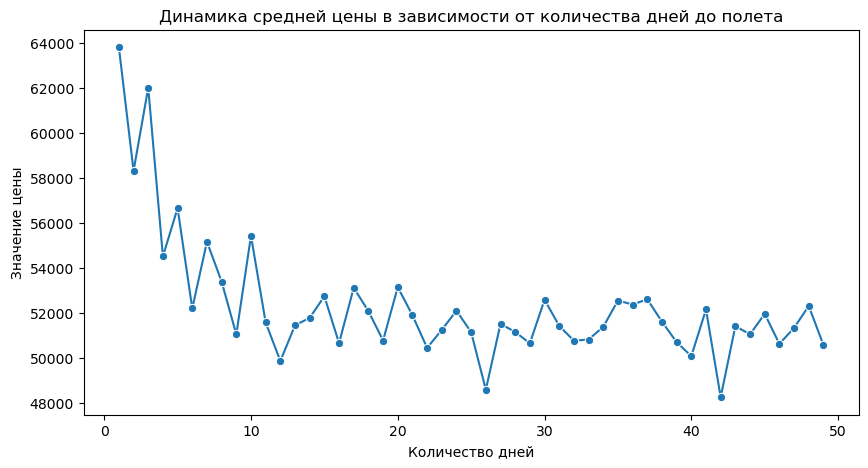

In [14]:
df_2 = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x='days_left',y='price',data=df_2,marker='o' )
plt.title('Динамика средней цены в зависимости от количества дней до полета')
plt.xlabel('Количество дней')
plt.ylabel('Значение цены')
plt.show()

<a class="anchor" id="3.4"></a>**Вывод**
* Цены на билеты значительно выше, если бронировать их за несколько дней до вылета (1-5 дней). Это объясняется тем, что в последние дни до вылета остаются билеты для тех, кому необходимо срочно улететь (например, бизнес-поездки) и спрос на них выше.
* После первоначального снижения, цены стабилизируются и колеблются в относительно небольшом диапазоне, если бронировать билеты за 15-50 дней до вылета.
* Наблюдается тенденция к снижению средней цены при увеличении количества дней до вылета, особенно в первые 10-15 дней. Это связано с тем, что авиакомпании стараются заполнить рейсы заранее, предлагая более низкие цены.

[Вернуться в начало раздела](#3)

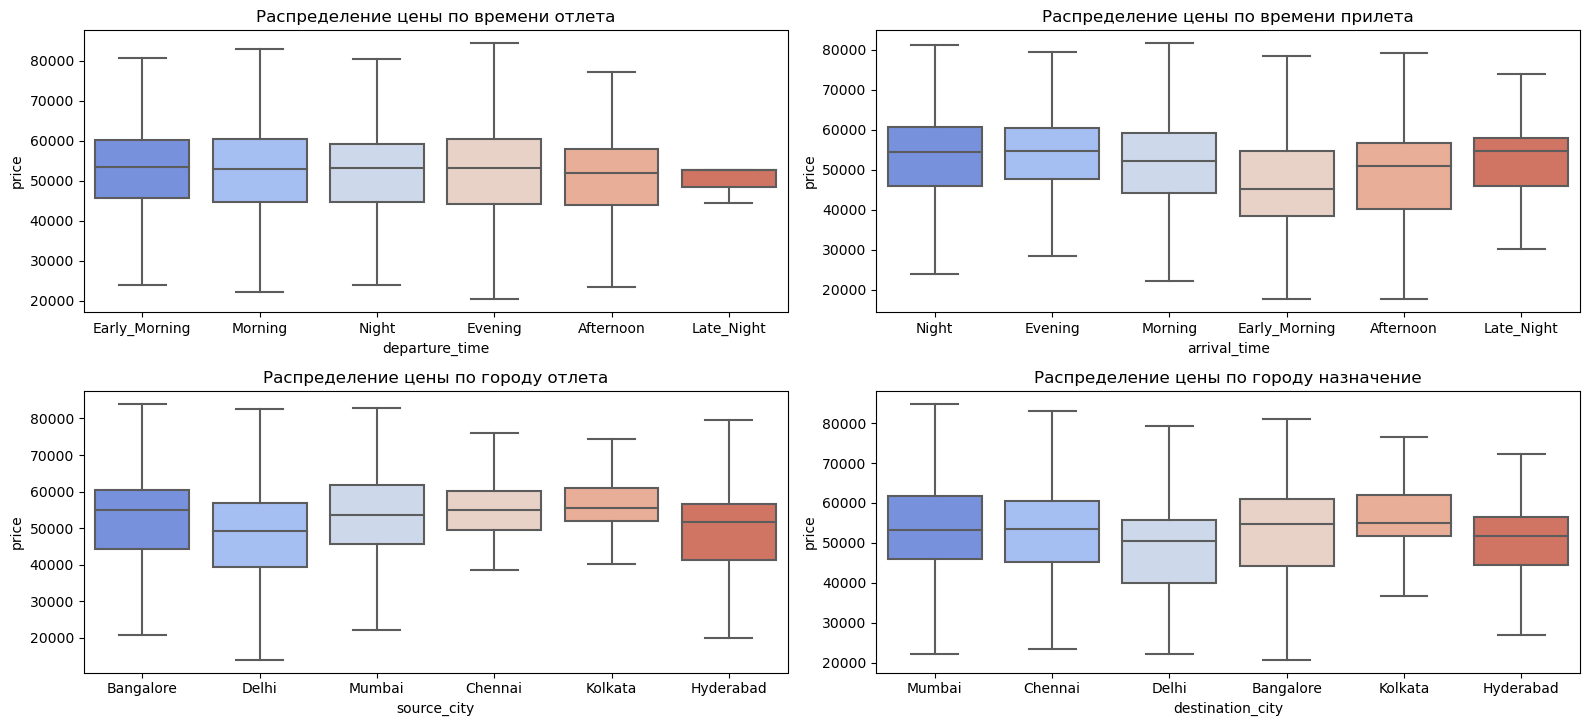

In [15]:
sns.set_palette("coolwarm")
plt.figure(figsize = (16,8))
plt.subplot(2,2,1)
sns.boxplot(x='departure_time', y='price', data=df, showfliers=False)
plt.title('Распределение цены по времени отлета')

plt.subplot(2,2,2)
sns.boxplot(x='arrival_time', y='price', data=df, showfliers=False)
           
plt.title('Распределение цены по времени прилета')

plt.subplot(2,2,3)
sns.boxplot(x='source_city', y='price', data=df, showfliers=False)          
plt.title('Распределение цены по городу отлета')

plt.subplot(2,2,4)
sns.boxplot(x='destination_city', y='price', data=df, showfliers=False)
           
plt.title('Распределение цены по городу назначение')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Данная визуализация подтверждает сказанное ранее

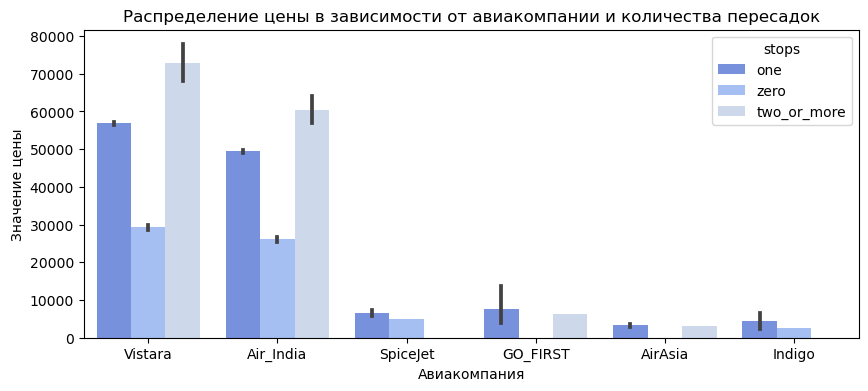

In [16]:
plt.figure(figsize=(10, 4))

sns.barplot(x='airline', y='price', hue='stops', data=df)
plt.title("Распределение цены в зависимости от авиакомпании и количества пересадок")
plt.xlabel("Авиакомпания")
plt.ylabel("Значение цены")
plt.show()

In [17]:
df_airlines_1 = df[df['airline'].isin(['Vistara', 'Air_India'])]
df_airlines_2 = df[df['airline'].isin(['SpiceJet', 'GO_FIRST', 'AirAsia', 'Indigo'])]
print(f'В датасете с Vistara и Air_India {df_airlines_1.shape[0]} значений, в датасете с остальными компаниями {df_airlines_2.shape[0]} значений')

В датасете с Vistara и Air_India 5684 значений, в датасете с остальными компаниями 14 значений


<a class="anchor" id="3.5"></a>**Вывод**

Общие тенденции:

* Vistara и Air_India - самые дорогие авиакомпании: В целом, цены на билеты этих авиакомпаний выше, чем у остальных, особенно для рейсов с пересадками.
* Бюджетные авиакомпании: SpiceJet, AirAsia и Indigo - это бюджетные авиакомпании, поэтому у них цены на билеты значительно ниже.
* Более 5000 наблюдений для авиакомпаний Vistara и Air_India, в то время, как для остальных - 14. Из этого следует, что, возможно, удаление выбросов из датасета приведет к практически полному удалению  значений компаний SpiceJet, AirAsia и Indigo, тогда будет иметь смысл строить модель прогноза только для двух компаний. Данное предположение будет [проверено далее](#1.1).

Авиакомпании и пересадки:

* У Vistara и Air_India наблюдается значительное увеличение цены при наличии пересадок. Полеты с двумя и более пересадками (“two_or_more”) самые дорогие.
* Для бюджетных авиакомпаний, влияние количества пересадок на цену не так значительно.

[Вернуться в начало раздела](#3)

## <a class="anchor" id="4"></a>4. Кодирование переменных, обработка выбросов
[Вернуться к навигации](#0)
В данной части работы будут осуществлены несколько способов кодирования переменных:
* Кодирование с добавлением фиктивных переменных (OneHotEncoder)
* Кодирование LabelEncoder

Дополнительно будут созданы датасеты без выбросов (удаление выбросов с помощью IQR)
<br>

In [18]:
#создадим копию датасета
df_q = df.copy()
df_airlines_1_q = df_airlines_1.copy() #датасет с 'Vistara', 'Air_India'
#обработка выбросов с помощью IQR 
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
df_q = remove_outliers_iqr(df_q, 'price')
df_q = remove_outliers_iqr(df_q, 'duration')

df_airlines_1_q = remove_outliers_iqr(df_airlines_1_q, 'duration')
df_airlines_1_q = remove_outliers_iqr(df_airlines_1_q, 'price')

print("после удаления выбросов размерность датасета составляет:",df_q.shape)

после удаления выбросов размерность датасета составляет: (5521, 9)


<a class="anchor" id="1.1"></a> Посмотрим на число уникальных авиакомпаний в датасете без выбросов

In [19]:
df_q.airline.unique()

array(['Vistara', 'Air_India'], dtype=object)

В случае с удалением выбросов с помощью IQR [**предположение подтвердилось**](#3.5), в датасете остались только 2 авиакомпании, дополнительно построим модель только для датасета, который состоит из 'Vistara', 'Air_India'.
<br>

In [20]:
df_airlines_1_q_en = df_airlines_1_q.copy() #датасет с 'Vistara', 'Air_India'
df_q_encoded = df_q.copy()
def encode_features(df, columns):
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df

columns_to_encode = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city']
df_airlines_1_q_en = encode_features(df_airlines_1_q_en, columns_to_encode)
df_q_encoded = encode_features(df_q_encoded, columns_to_encode)

In [21]:
df_airlines_1_q_one = df_airlines_1_q.copy() #датасет с 'Vistara', 'Air_India'
df_q_onehot = df_q.copy()
def encode_features_onehot(df, columns):
    encoders = {}
    for column in columns:
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        reshaped = df[[column]]
        encoded_values = ohe.fit_transform(reshaped)
        categories = ohe.categories_[0]
        categories_dropped = categories[1:]
        encoded_df = pd.DataFrame(
            encoded_values[:, 1:],  # пропускаем первый столбец
            columns=[f"{column}_{category}" for category in categories_dropped],
            index=df.index
        )
        df = pd.concat([df.drop(column, axis=1), encoded_df], axis=1)
        encoders[column] = ohe
    return df

columns_to_encode = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city']
df_airlines_1_q_one = encode_features_onehot(df_airlines_1_q_one, columns_to_encode)
df_q_onehot = encode_features_onehot(df_q_onehot, columns_to_encode)

## <a class="anchor" id="5"></a>5. Признак важности по Шепли
[Вернуться к навигации](#0)
<br>
Посмотрим на ранжирование переменных по важности (Шепли) для каждого датасета: 
1. датасета c кодированием LabelEncoder
2. датасета с компаниями 'Vistara', 'Air_India' и кодированием LabelEncoder
3. датасета c OneHotEncoder
4. датасета с компаниями 'Vistara', 'Air_India' и кодированием OneHotEncoder

Результат будет использован [далее](#6.1)

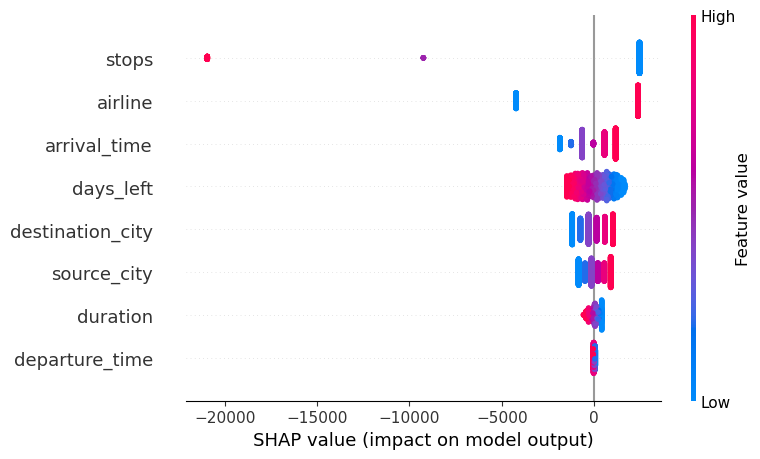

In [22]:
X = df_q_encoded.drop(['price'], axis=1)
y = df_q_encoded[['price']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

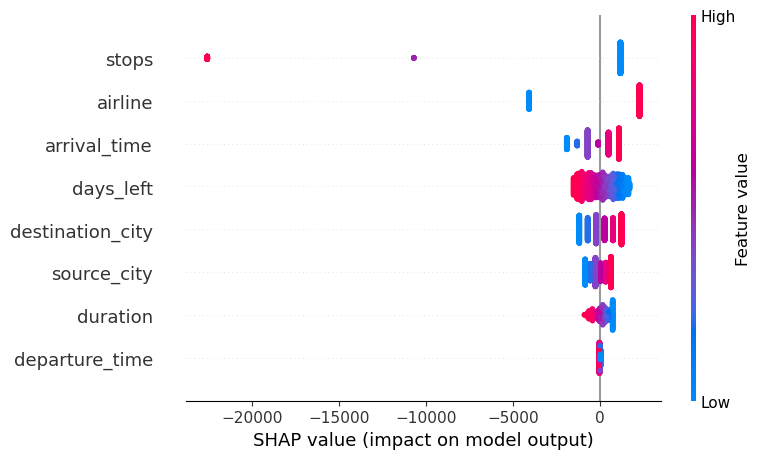

In [23]:
X = df_airlines_1_q_en.drop(['price'], axis=1)
y = df_airlines_1_q_en[['price']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

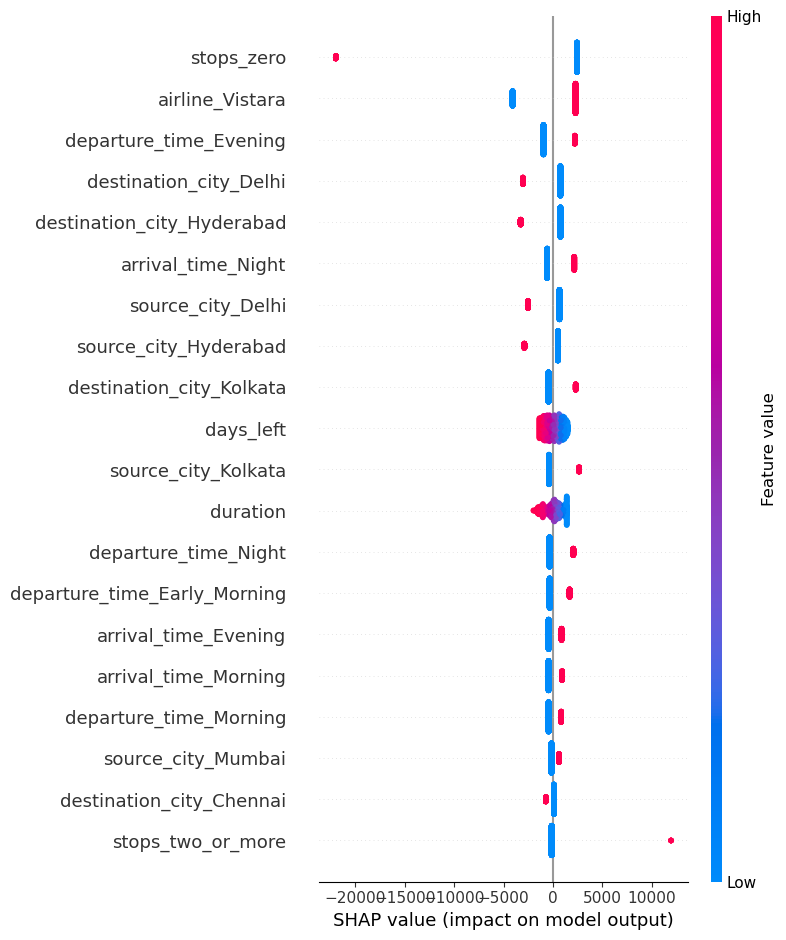

In [24]:
X = df_q_onehot.drop(['price'], axis=1)
y = df_q_onehot[['price']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

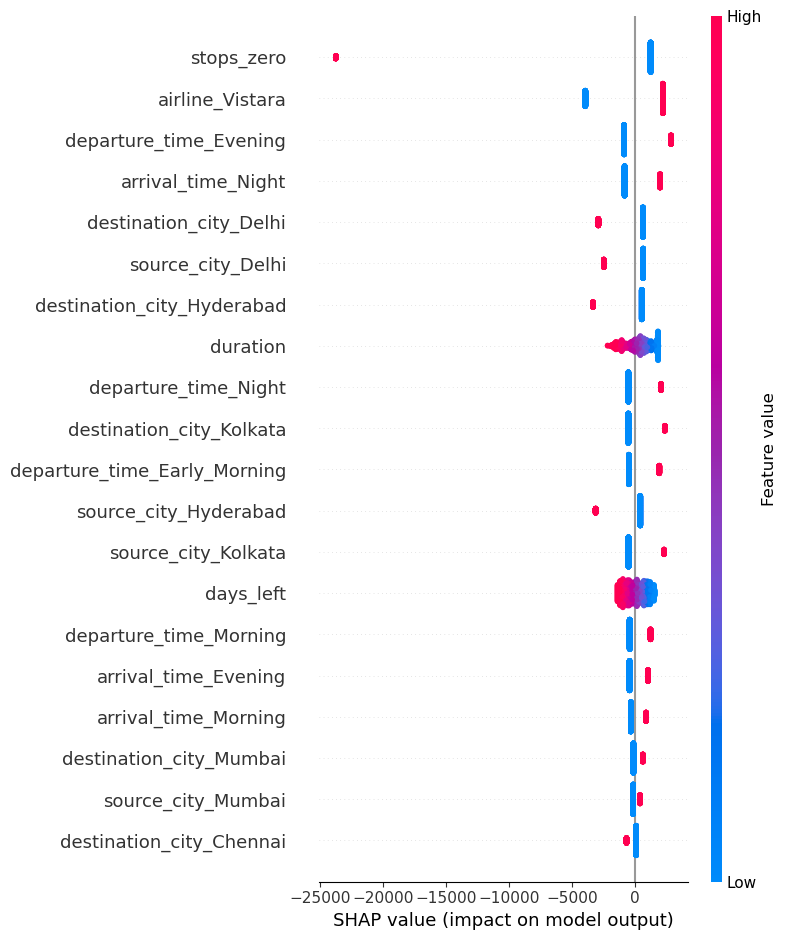

In [25]:
X = df_airlines_1_q_one.drop(['price'], axis=1)
y = df_airlines_1_q_one[['price']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

[Вернуться в начало раздела](#5) 

## <a class="anchor" id="6"></a>6. Модель прогноза цены авиабилета
[Вернуться к навигации](#0)
<br>

Создадим функцию для проверки разных моделей: 
* Linear Regression
* Lasso Regression
* Ridge Regression
* Decision Tree
* Random Forest
* K Neighbors
* Gradient Boosting

И разных типов масштабирования: 

* StandardScaler
* MinMaxScaler
* RobustScaler

In [26]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def price_model(x, y, scaling_method):
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Decision Tree': DecisionTreeRegressor(random_state=1),
        'Random Forest': RandomForestRegressor(random_state=1),
        'K Neighbors': KNeighborsRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(random_state=1)
    }

    results = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Масштабирование признаков
    if scaling_method == 'StandardScaler':
        scaler = StandardScaler()
    elif scaling_method == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaling_method == 'RobustScaler':
        scaler = RobustScaler()

    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Обучение моделей и вычисление метрик
    n_test = x_test.shape[0]  # Количество наблюдений в тестовом наборе
    p = x_test.shape[1]  # Количество признаков
    for n, model in models.items():
        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = adjusted_r2(r2, n_test, p) # Вычисляем adjusted R^2
        results[n] = {'Adjusted R²': adj_r2}  # Сохраняем adjusted R^2

    # Создаем DataFrame из результатов
    results_df = pd.DataFrame(results).T

    return results_df, y_pred, y_test

def highlight_max(s):
    is_max = s == s.max() 
    return ['background-color: lightgreen' if v else '' for v in is_max]

### Вариант 1: датасета с компаниями 'Vistara', 'Air_India' и кодированием LabelEncoder

In [27]:
# Создаем пустой DataFrame для хранения всех результатов
all_results = pd.DataFrame()
scalers = ['RobustScaler', 'MinMaxScaler', 'StandardScaler']

# Перебираем методы масштабирования
for scaler_method in scalers:
    x = df_airlines_1_q_en.drop(['price'], axis=1)
    y = df_airlines_1_q_en[['price']]

    results_df, y_pred, y_test = price_model(
        x, y.values.ravel(),
        scaling_method=scaler_method
    )
    results_df['scaler'] = scaler_method
    all_results = pd.concat([all_results, results_df], axis=0)

all_results = all_results.reset_index()
all_results = all_results.rename(columns={'index': 'model'})

# Применяем стилизацию для подсветки максимальных Adjusted R²
styled_results = all_results.style.apply(highlight_max, subset=['Adjusted R²'], axis=0)
styled_results

,model,Adjusted R²,scaler
0,Linear Regression,0.404977,RobustScaler
1,Lasso Regression,0.404952,RobustScaler
2,Ridge Regression,0.404939,RobustScaler
3,Decision Tree,0.557023,RobustScaler
4,Random Forest,0.739883,RobustScaler
5,K Neighbors,0.543705,RobustScaler
6,Gradient Boosting,0.588487,RobustScaler
7,Linear Regression,0.404977,MinMaxScaler
8,Lasso Regression,0.404935,MinMaxScaler
9,Ridge Regression,0.404872,MinMaxScaler


### Вариант 2: датасета c кодированием LabelEncoder

In [28]:
# Создаем пустой DataFrame для хранения всех результатов
all_results = pd.DataFrame()
scalers = ['RobustScaler', 'MinMaxScaler', 'StandardScaler']

# Перебираем методы масштабирования
for scaler_method in scalers:
    x = df_q_encoded.drop(['price'], axis=1)
    y = df_q_encoded[['price']]

    results_df, y_pred, y_test = price_model(
        x, y.values.ravel(),
        scaling_method=scaler_method
    )
    results_df['scaler'] = scaler_method
    all_results = pd.concat([all_results, results_df], axis=0)

all_results = all_results.reset_index()
all_results = all_results.rename(columns={'index': 'model'})

# Применяем стилизацию для подсветки максимальных Adjusted R²
styled_results = all_results.style.apply(highlight_max, subset=['Adjusted R²'], axis=0)
styled_results

,model,Adjusted R²,scaler
0,Linear Regression,0.393170,RobustScaler
1,Lasso Regression,0.393141,RobustScaler
2,Ridge Regression,0.393128,RobustScaler
3,Decision Tree,0.577589,RobustScaler
4,Random Forest,0.731002,RobustScaler
5,K Neighbors,0.534683,RobustScaler
6,Gradient Boosting,0.582511,RobustScaler
7,Linear Regression,0.393170,MinMaxScaler
8,Lasso Regression,0.393131,MinMaxScaler
9,Ridge Regression,0.393076,MinMaxScaler


### Вариант 3: датасета с компаниями 'Vistara', 'Air_India' и кодированием OneHotEncoder

In [29]:
# Создаем пустой DataFrame для хранения всех результатов
all_results = pd.DataFrame()
scalers = ['RobustScaler', 'MinMaxScaler', 'StandardScaler']

# Перебираем методы масштабирования
for scaler_method in scalers:
    x = df_airlines_1_q_one.drop(['price'], axis=1)
    y = df_airlines_1_q_one[['price']]

    results_df, y_pred, y_test = price_model(
        x, y.values.ravel(),
        scaling_method=scaler_method
    )
    results_df['scaler'] = scaler_method
    all_results = pd.concat([all_results, results_df], axis=0)

all_results = all_results.reset_index()
all_results = all_results.rename(columns={'index': 'model'})

# Применяем стилизацию для подсветки максимальных Adjusted R²
styled_results = all_results.style.apply(highlight_max, subset=['Adjusted R²'], axis=0)
styled_results

,model,Adjusted R²,scaler
0,Linear Regression,0.484054,RobustScaler
1,Lasso Regression,0.483853,RobustScaler
2,Ridge Regression,0.484145,RobustScaler
3,Decision Tree,0.549547,RobustScaler
4,Random Forest,0.746931,RobustScaler
5,K Neighbors,0.580585,RobustScaler
6,Gradient Boosting,0.586445,RobustScaler
7,Linear Regression,0.484054,MinMaxScaler
8,Lasso Regression,0.483838,MinMaxScaler
9,Ridge Regression,0.484132,MinMaxScaler


### Вариант 4: датасета c кодированием OneHotEncoder

In [30]:
# Создаем пустой DataFrame для хранения всех результатов
all_results = pd.DataFrame()
scalers = ['RobustScaler', 'MinMaxScaler', 'StandardScaler']

# Перебираем методы масштабирования
for scaler_method in scalers:
    x = df_q_onehot.drop(['price'], axis=1)
    y = df_q_onehot[['price']]

    results_df, y_pred, y_test = price_model(
        x, y.values.ravel(),
        scaling_method=scaler_method
    )
    results_df['scaler'] = scaler_method
    all_results = pd.concat([all_results, results_df], axis=0)

all_results = all_results.reset_index()
all_results = all_results.rename(columns={'index': 'model'})

# Применяем стилизацию для подсветки максимальных Adjusted R²
styled_results = all_results.style.apply(highlight_max, subset=['Adjusted R²'], axis=0)
styled_results

,model,Adjusted R²,scaler
0,Linear Regression,0.473125,RobustScaler
1,Lasso Regression,0.473767,RobustScaler
2,Ridge Regression,0.473577,RobustScaler
3,Decision Tree,0.557303,RobustScaler
4,Random Forest,0.740459,RobustScaler
5,K Neighbors,0.567740,RobustScaler
6,Gradient Boosting,0.580731,RobustScaler
7,Linear Regression,0.473125,MinMaxScaler
8,Lasso Regression,0.473761,MinMaxScaler
9,Ridge Regression,0.473571,MinMaxScaler


**На данном этапе лучшая модель: вариант 3. 

<a class="anchor" id="6.1"></a>**Попробуем удалить переменные из Х [по признаку важности Шепли](#5).**

In [31]:
# Создаем пустой DataFrame для хранения всех результатов
all_results = pd.DataFrame()
scalers = ['RobustScaler', 'MinMaxScaler', 'StandardScaler']

# Перебираем методы масштабирования
for scaler_method in scalers:
    x = df_airlines_1_q_one.drop(['price', 'source_city_Mumbai', 'destination_city_Chennai'], axis=1)
    y = df_airlines_1_q_one[['price']]

    results_df, y_pred, y_test = price_model(
        x, y.values.ravel(),
        scaling_method=scaler_method
    )
    results_df['scaler'] = scaler_method
    all_results = pd.concat([all_results, results_df], axis=0)

all_results = all_results.reset_index()
all_results = all_results.rename(columns={'index': 'model'})

# Применяем стилизацию для подсветки максимальных Adjusted R²
styled_results = all_results.style.apply(highlight_max, subset=['Adjusted R²'], axis=0)
styled_results

,model,Adjusted R²,scaler
0,Linear Regression,0.483026,RobustScaler
1,Lasso Regression,0.482910,RobustScaler
2,Ridge Regression,0.483132,RobustScaler
3,Decision Tree,0.505095,RobustScaler
4,Random Forest,0.719946,RobustScaler
5,K Neighbors,0.553484,RobustScaler
6,Gradient Boosting,0.570064,RobustScaler
7,Linear Regression,0.483026,MinMaxScaler
8,Lasso Regression,0.482896,MinMaxScaler
9,Ridge Regression,0.483119,MinMaxScaler


**Удаление только ухудшило значение метрики**

## <a class="anchor" id="7"></a> Лучший результат
[Вернуться к навигации](#0)


После проведения экспериментов с различными моделями, методами масштабирования, способами кодирования категориальных признаков были получены следующие ключевые результаты, касающиеся прогнозирования цен на авиабилеты.
<br>

**Общий датасет (все авиакомпании):**
* Модель: Random Forest Regressor
* Масштабирование: RobustScaler
* Кодирование категориальных признаков: OneHotEncoder
* Обработка выбросов: Удаление выбросов на основе межквартильного размаха (IQR)
* Метрика: $ R²_{скорр} = 0.740459 $
<br>

**Датасет с Vistara и Air_India:**
* Модель: Random Forest Regressor
* Масштабирование: StandardScaler
* Кодирование категориальных признаков: OneHotEncoder
* Обработка выбросов: Удаление выбросов на основе межквартильного размаха (IQR)
* Метрика:<span style="color:green"> $ R²_{скорр} = 0.747426 $ </span>
<br>

Как видно из результатов, удаление данных по другим авиакомпаниям привело к увеличению $ R²_{скорр}$. Это свидетельствует о том, что модели, обученные на более однородных данных (в данном случае, данные только по Vistara и Air_India), обладают лучшей обобщающей способностью и позволяют более точно прогнозировать цены на авиабилеты. Возможно, ценовая политика других авиакомпаний значительно отличалась от Vistara и Air_India, что вносило дополнительный шум в данные и ухудшало качество прогноза для общей модели.

Отметим, что в обоих вариантах лучшая модель - **Random Forest Regressor**, представляющая собой ансамбль деревьев решений. Random Forest отличается высокой устойчивостью к переобучению и способностью улавливать сложные нелинейные зависимости в данных, что делает его подходящим для задач прогнозирования с большим количеством признаков.

In [32]:
X = df_airlines_1_q_one.drop('price', axis=1)
y = df_airlines_1_q_one['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = RandomForestRegressor(random_state=1)  
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

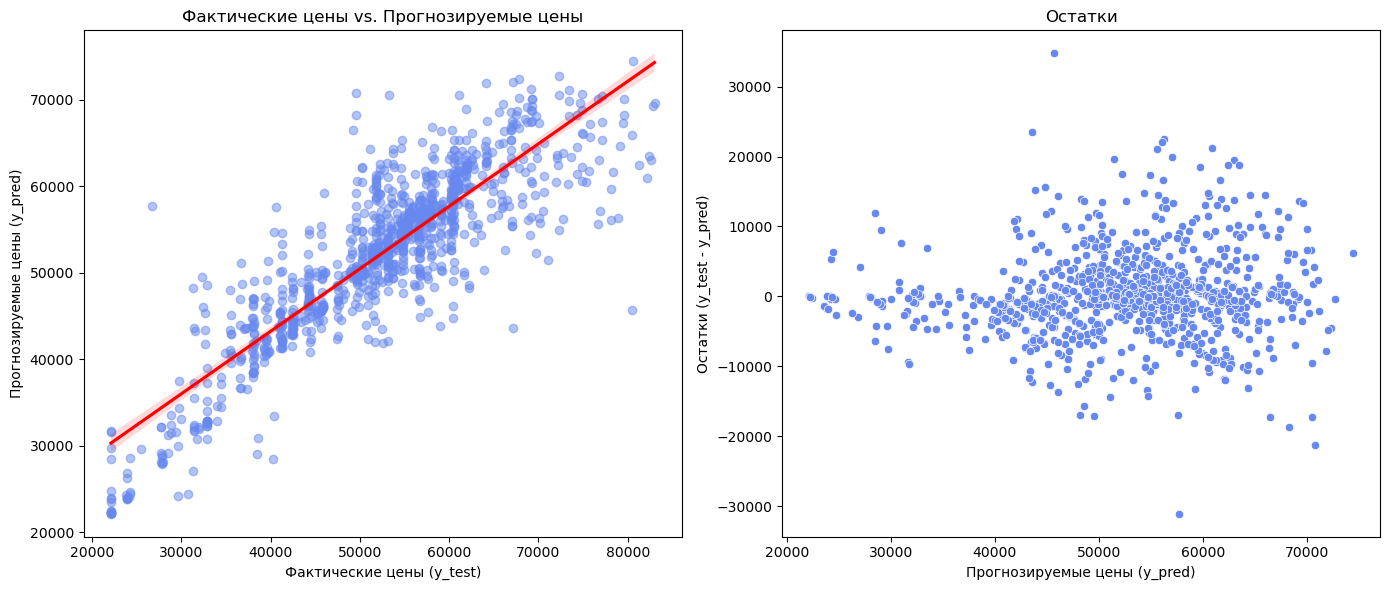

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Визуализация прогнозов vs. фактических значений
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={"color": "red"}, ax=axes[0])
axes[0].set_xlabel("Фактические цены (y_test)")
axes[0].set_ylabel("Прогнозируемые цены (y_pred)")
axes[0].set_title("Фактические цены vs. Прогнозируемые цены")

# Визуализация остатков
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
axes[1].set_xlabel("Прогнозируемые цены (y_pred)")
axes[1].set_ylabel("Остатки (y_test - y_pred)")
axes[1].set_title("Остатки") 

plt.tight_layout()
plt.show()